<a href="https://colab.research.google.com/github/jpeele49/dolphin_whale_classification/blob/master/06_conv_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from gc import callbacks

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/drive/MyDrive/dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 150; 
img_width = 150;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        


Found 11179 files belonging to 2 classes.
Using 8944 files for training.
Found 11179 files belonging to 2 classes.
Using 2235 files for validation.


# Visualize a Training Batch

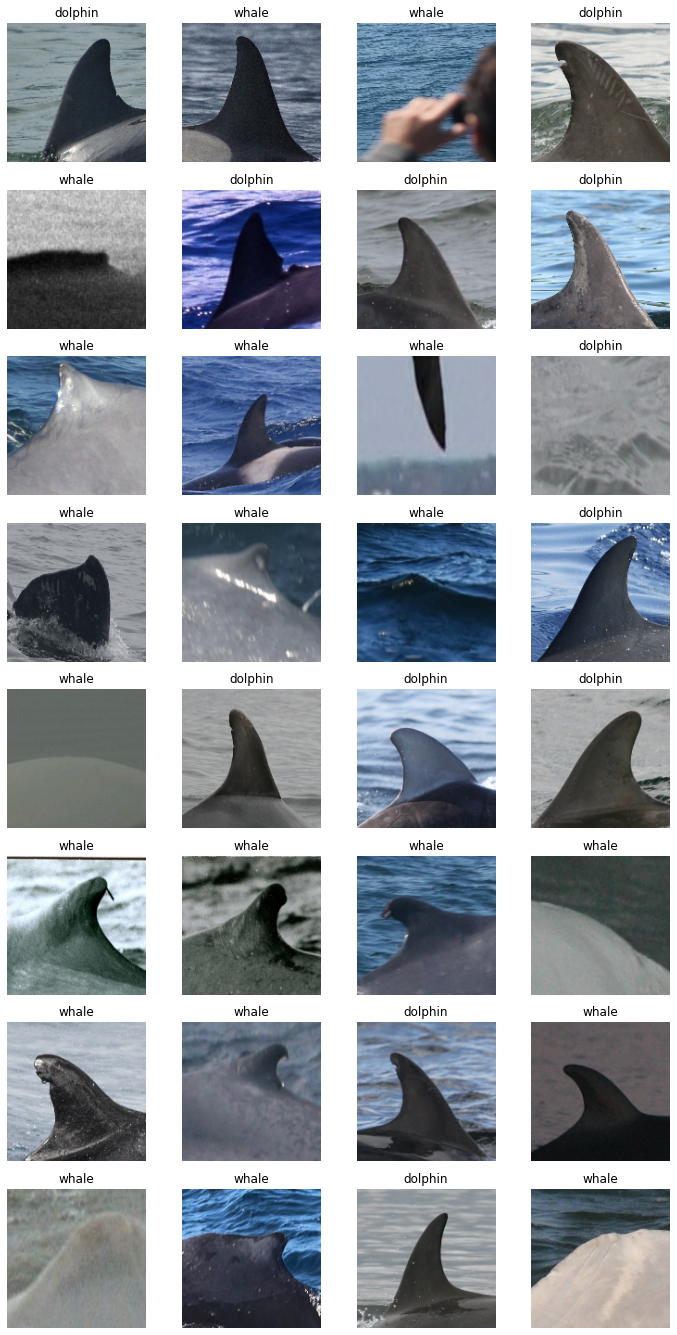

In [ ]:
class_names = ['dolphin', 'whale']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

# Data Augmentation

In [ ]:
data_aug = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

train_aug = train_ds.map(lambda x, y: (data_aug(x), y))

# Preprocess Data and Define Early Stopping

In [ ]:
def preprocess_R(image, label):
  final_image = keras.applications.resnet.preprocess_input(image)
  return final_image, label

train_R = train_aug.map(preprocess_R).prefetch(1)
valid_R = validation_ds.map(preprocess_R).prefetch(1)

def preprocess_E(image, label):
  final_image = keras.applications.efficientnet.preprocess_input(image)
  return final_image, label

train_E = train_aug.map(preprocess_E).prefetch(1)
valid_E = validation_ds.map(preprocess_E).prefetch(1)

def preprocess_D(image, label):
  final_image = keras.applications.densenet.preprocess_input(image)
  return final_image, label

train_D = train_aug.map(preprocess_D).prefetch(1)
valid_D = validation_ds.map(preprocess_D).prefetch(1)

callback = tf.keras.callbacks.EarlyStopping(patience=3)

# Fit ResNet Model

In [ ]:
base_model_R = keras.applications.resnet.ResNet152(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model_R.output)
output = keras.layers.Dense(18, activation="softmax")(avg)
model_R = keras.Model(inputs=base_model_R.input, outputs=output)

for layer in base_model_R.layers:
    layer.trainable = False

model_R.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model_R.fit(train_R, epochs=10, validation_data=train_R, callbacks=[callback])

Epoch 1/10
280/280 [==============================] - 288s 996ms/step - loss: 0.3718 - accuracy: 0.8494 - val_loss: 0.2757 - val_accuracy: 0.8881
Epoch 2/10
280/280 [==============================] - 290s 1s/step - loss: 0.2713 - accuracy: 0.8889 - val_loss: 0.2346 - val_accuracy: 0.9119
Epoch 3/10
280/280 [==============================] - 277s 989ms/step - loss: 0.2458 - accuracy: 0.8961 - val_loss: 0.2214 - val_accuracy: 0.9141
Epoch 4/10
280/280 [==============================] - 282s 1s/step - loss: 0.2251 - accuracy: 0.9080 - val_loss: 0.2524 - val_accuracy: 0.9034
Epoch 5/10
280/280 [==============================] - 282s 1s/step - loss: 0.2225 - accuracy: 0.9084 - val_loss: 0.2152 - val_accuracy: 0.9168
Epoch 6/10
280/280 [==============================] - 278s 992ms/step - loss: 0.2120 - accuracy: 0.9166 - val_loss: 0.2063 - val_accuracy: 0.9181
Epoch 7/10
280/280 [==============================] - 279s 997ms/step - loss: 0.2078 - accuracy: 0.9154 - val_loss: 0.2358 - val_accu

# ResNet Yields 93% Validation Accuracy

In [ ]:
model_R.evaluate(train_R)

70/70 [==============================] - 55s 771ms/step - loss: 0.1995 - accuracy: 0.9266


[0.19951149821281433, 0.9266219139099121]

# Fit EfficientNet Model

In [ ]:
base_model_E = keras.applications.EfficientNetV2L(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model_E.output)
output = keras.layers.Dense(18, activation="softmax")(avg)
model_E = keras.Model(inputs=base_model_E.input, outputs=output)

for layer in base_model_E.layers:
    layer.trainable = False

callback = tf.keras.callbacks.EarlyStopping(patience=3)

model_E.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model_E.fit(train_E, epochs=10, validation_data=valid_E, callbacks=[callback])

Epoch 1/10
280/280 [==============================] - 357s 1s/step - loss: 0.5484 - accuracy: 0.7917 - val_loss: 0.3730 - val_accuracy: 0.8555
Epoch 2/10
280/280 [==============================] - 330s 1s/step - loss: 0.3390 - accuracy: 0.8638 - val_loss: 0.3284 - val_accuracy: 0.8680
Epoch 3/10
280/280 [==============================] - 332s 1s/step - loss: 0.3055 - accuracy: 0.8786 - val_loss: 0.3075 - val_accuracy: 0.8770
Epoch 4/10
280/280 [==============================] - 331s 1s/step - loss: 0.2872 - accuracy: 0.8860 - val_loss: 0.2967 - val_accuracy: 0.8850
Epoch 5/10
280/280 [==============================] - 330s 1s/step - loss: 0.2750 - accuracy: 0.8924 - val_loss: 0.2885 - val_accuracy: 0.8881
Epoch 6/10
280/280 [==============================] - 330s 1s/step - loss: 0.2655 - accuracy: 0.8976 - val_loss: 0.2818 - val_accuracy: 0.8926
Epoch 7/10
280/280 [==============================] - 330s 1s/step - loss: 0.2576 - accuracy: 0.9012 - val_loss: 0.2777 - val_accuracy: 0.8922

# EfficientNet Yields 90% Accuracy

In [ ]:
model_E.evaluate(valid_E)

70/70 [==============================] - 65s 930ms/step - loss: 0.2685 - accuracy: 0.8966


[0.268501341342926, 0.8966442942619324]

# Fit DenseNet

In [ ]:
base_model_D = keras.applications.DenseNet201(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model_D.output)
output = keras.layers.Dense(18, activation="softmax")(avg)
model_D = keras.Model(inputs=base_model_D.input, outputs=output)

for layer in base_model_E.layers:
    layer.trainable = False

callback = tf.keras.callbacks.EarlyStopping(patience=3)

model_D.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model_D.fit(train_D, epochs=10, validation_data=valid_D, callbacks=[callback])

Epoch 1/10
280/280 [==============================] - 845s 3s/step - loss: 0.3936 - accuracy: 0.8529 - val_loss: 2.3400 - val_accuracy: 0.7705
Epoch 2/10
280/280 [==============================] - 768s 3s/step - loss: 0.2530 - accuracy: 0.8962 - val_loss: 0.3303 - val_accuracy: 0.8805
Epoch 3/10
280/280 [==============================] - 812s 3s/step - loss: 0.2195 - accuracy: 0.9100 - val_loss: 0.3075 - val_accuracy: 0.8609
Epoch 4/10
280/280 [==============================] - 832s 3s/step - loss: 0.1867 - accuracy: 0.9239 - val_loss: 0.5037 - val_accuracy: 0.8747
Epoch 5/10
280/280 [==============================] - 790s 3s/step - loss: 0.1685 - accuracy: 0.9330 - val_loss: 0.2264 - val_accuracy: 0.9195
Epoch 6/10
280/280 [==============================] - 794s 3s/step - loss: 0.1578 - accuracy: 0.9330 - val_loss: 0.2619 - val_accuracy: 0.8931
Epoch 7/10
280/280 [==============================] - 769s 3s/step - loss: 0.1565 - accuracy: 0.9371 - val_loss: 0.5395 - val_accuracy: 0.8018

# DenseNet Yields 91% Accuracy

In [ ]:
model_D.evaluate(valid_D)

70/70 [==============================] - 28s 397ms/step - loss: 0.2481 - accuracy: 0.9078


[0.24812333285808563, 0.907829999923706]